# Assignment 4: Supervised Learning, Decision Trees, Random Forests, and SVM Models

**Objective:** In this assignment we will develop predictive models - decision trees, random forest, and SVM models from sklearn library. We will also experiment with grid search and random search.


Please do not share this material on any platform or by any other means.

Important Notes:

    Make changes to the cells that have # YOUR CODE HERE or # YOUR COMMENT HERE.Do not write your answer in anywhere else other than where it says YOUR CODE HERE (or YOUR COMMENT HERE).

    Your code must run without any errors start to end. Please go to menubar, select Kernel, and restart the kernel and run all cells (Restart & Run all) before submitting your work.

    Purpose of the assignment is to assess your knowledge and command of the data mining algorithms, python programming language, and your ability to resolve common errors. Grading is based on the code and your interpretation/comments you are submitting, not the formatting of the results.

    Please use the examples as a guideline, you are not expected to have the same formatting as the example, unless it is a formatting question.

Remember, there are many ways to code that can lead to the correct answer, do not hesitate to exercise your own style and python programming coventions.

In this assignment you'll develop an understanding of decision trees, random forest using a mock-dataset called moons dataset, then build a SVM model to predict the California dataset. 

## PART 1: DECISION TREES

### Q1: Generate a moons dataset using make_moons(n_samples=10000, noise=0.4).
Random state = 42.

In [1]:
#YOUR CODE HERE
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=10000, noise=0.4, random_state= 42)

If you are successful in creating the dataset, it may look like this:

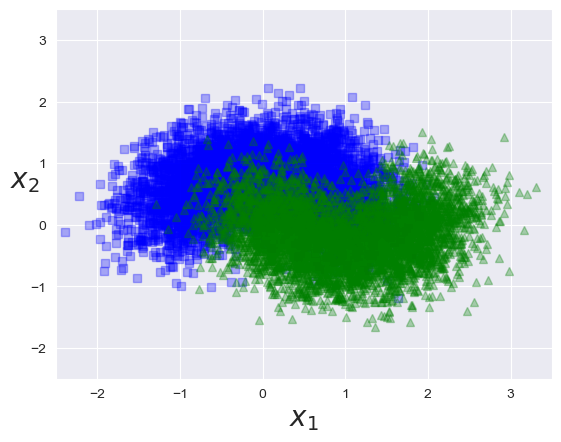

In [2]:
import matplotlib.pyplot as plt
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs",alpha=0.3)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^",alpha=0.3)
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-2.5, 3.5, -2.5, 3.5])
plt.show();

### Q2:  Split the data into a training set and a test set using train_test_split().
Random state = 42.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)

### Q3: Use grid search with cross-validation (with the help of the GridSearchCV class) to find good hyperparameter values for a DecisionTreeClassifier. 
Test various values for max_leaf_nodes.

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, KFold

naive_decision_tree = DecisionTreeClassifier(random_state=42)

kfold = KFold(n_splits=5)

param_grid = {
    'max_leaf_nodes': [i for i in range (2,30)]
}

# Setting up the grid search with decision tree, parameter grid, and cross-validation strategy
grid_search = GridSearchCV(naive_decision_tree, param_grid, cv=kfold, n_jobs=-1)
    
# Fitting the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters found
best_params_lr = grid_search.best_params_

In [37]:
print(f"Best Parameters: {best_params_lr}")

Best Parameters: {'max_leaf_nodes': 26}


### Q4: Train it on the full training set using these hyperparameters, and measure your model's performance on the test set. 
You may get roughly 85% to 87% accuracy.

In [39]:
from sklearn.metrics import classification_report
from sklearn.base import clone

best_decision_tree = clone(grid_search.best_estimator_)

best_decision_tree.fit(X_train,y_train)

y_pred = best_decision_tree.predict(X_test)

# Print classification report for test data
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1013
           1       0.86      0.88      0.87       987

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000


Precision:
* Class 0: 0.88 precision means that 88% of the instances predicted as class 0 were actually class 0.
* Class 1: 0.86 precision means that 86% of the instances predicted as class 1 were actually class 1.

Recall:
* Class 0: 0.86 recall means that the model correctly identified 86% of all actual class 0 instances.
* Class 1: 0.88 recall means that the model correctly identified 88% of all actual class 1 instances.

F-1 Score:
* For both classes, the F1-score is 0.87, indicating a good balance between precision and recall for both classes.

Support:
* Class 0 has 1013 instances.
* Class 1 has 987 instances.

Overall Accuracy:
* The overall accuracy of 0.87 indicates that 87% of all predictions (for both classes combined) were correct.



## Creating many decision trees

Let's continue to use the same dataset as before and generate 1,000 subsets of the training set, each containing 100 instances selected randomly. We will use Scikit-Learn's ```ShuffleSplit``` class for this:

In [40]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

Let's use the best estimater values we found in question 3, and 
(1) generate the 1000 trees, and call it our "forest"
(2) fit and calculate the accuracy scores for each decision tree

In [41]:
from sklearn.base import clone
from sklearn.metrics import accuracy_score
import numpy as np
forest = [clone(grid_search.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.7982159999999999

Since each decision tree is trained on a smaller dataset (100 examples) than the one in Q4 (10000 examples), the accuracy score is lower.  

### Majority Vote

For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy's mode() function for this). This gives you **majority-vote predictions** over the test set.

In [42]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)
for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [43]:
from scipy.stats import mode
y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

C:\Users\yzy_s\AppData\Local\Temp\ipykernel_42876\301116937.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)


In [44]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.8735

## PART 2: RANDOM FOREST

### Q5: Build a random forest model with 1000 trees, and check the accuracy score.
Random state = 42. 

In [45]:
from sklearn.ensemble import RandomForestClassifier

naive_rf = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)

naive_rf.fit(X_train, y_train)

y_pred = naive_rf.predict(X_test)

# Print classification report for test data
accuracy_score(y_test, y_pred)

0.8555

### Q6: Use GridSearchCV to find a Random Forest model, is it better or worse than 1000-Decision Trees majority vote (compare to Q5 accuracy)? 
Random state = 42. 

In your grid search, use max_leaf_nodes_options= list(range(2, 100)) and min_samples_split_options = [2, 3, 4]

In [32]:
kfold = KFold(n_splits=5)

param_grid = {
    "max_leaf_nodes" : [i for i in range(2,100)],
    "min_samples_split": [i for i in range(2,5)]
}

# Setting up the grid search with random forest, parameter grid, and cross-validation strategy
grid_search = GridSearchCV(naive_rf, param_grid, cv=kfold, n_jobs=-1)
    
# Fitting the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters found
best_params_lr = grid_search.best_params_

In [33]:
print(f"Best Parameters: {best_params_lr}")

Best Parameters: {'max_leaf_nodes': 47, 'min_samples_split': 3}


### Q7: If in Q6 you found a better accuracy score then Q5? explain how. If not continue to fine tune your model to find a higher accuracy.

Random state = 42. 
Hint: 87.7 is one possible accuracy. 

In [35]:
from sklearn.metrics import accuracy_score

best_rf = clone(grid_search.best_estimator_)

best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)

accuracy_score(y_test, y_pred)

0.873

Comparing to Q5, the accuracy score increases from 0.8555 to 0.873

## PART 3: ENSEMBLE MODEL


### Q8: Use the final Decision tree and Random Forest models that you created above, combine them with one/two more models of your choice and create an ensemble model

You can create an ensemble model by combining the outputs from your models i.e taking the majority of the output predictions as your final prediction. For eg. if for a specific classification problem of "Yes" or "No", you have 3 models and for a specific row, 2 of the models predicted a "Yes" then your ensemble model preiction will be a "Yes".

In [47]:
from sklearn.svm import SVC

naive_svm = SVC(random_state=42)

param_grid = {
    'C': [i / 100 for i in range(1, 201)],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced']
}

# Setting up the grid search with svm, parameter grid, and cross-validation strategy
grid_search = GridSearchCV(naive_svm, param_grid, cv=kfold, n_jobs=-1)
    
# Fitting the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters found
best_params_lr = grid_search.best_params_

In [48]:
print(f"Best Parameters: {best_params_lr}")

Best Parameters: {'C': 0.45, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


In [49]:
best_svm = clone(grid_search.best_estimator_)

best_svm.fit(X_train, y_train)

y_pred = best_svm.predict(X_test)

accuracy_score(y_test, y_pred)

0.872

### Q9. Summarize your results. Which of the models yielded the best predictions overall, and which models had the best precision, recall and AUC-ROC? Interpret the output.

Ensemble Model

In [56]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score

ensemble_model = VotingClassifier(estimators=[
    ('decision_tree', best_decision_tree),
    ('svm', best_svm),
    ('randomforest',best_rf)
])

# Train the model
ensemble_model.fit(X_train, y_train)

y_pred = ensemble_model.predict(X_test)

print(f"accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"recall score: {recall_score(y_test, y_pred)}")
print(f"precision score: {precision_score(y_test, y_pred)}")
print(f"AUC-ROC score: {roc_auc_score(y_test, y_pred)}")

accuracy score: 0.8745
recall score: 0.8814589665653495
precision score: 0.8665338645418327
AUC-ROC score: 0.874589305592645


Decision Tree

In [57]:
y_pred = best_decision_tree.predict(X_test)

print(f"accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"recall score: {recall_score(y_test, y_pred)}")
print(f"precision score: {precision_score(y_test, y_pred)}")
print(f"AUC-ROC score: {roc_auc_score(y_test, y_pred)}")

accuracy score: 0.872
recall score: 0.8834853090172239
precision score: 0.8608094768015795
AUC-ROC score: 0.8721473929094017


Random Forest

In [58]:
y_pred = best_rf.predict(X_test)

print(f"accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"recall score: {recall_score(y_test, y_pred)}")
print(f"precision score: {precision_score(y_test, y_pred)}")
print(f"AUC-ROC score: {roc_auc_score(y_test, y_pred)}")

accuracy score: 0.873
recall score: 0.8794326241134752
precision score: 0.8654037886340977
AUC-ROC score: 0.8730825509511106


SVM

In [59]:
y_pred = best_svm.predict(X_test)

print(f"accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"recall score: {recall_score(y_test, y_pred)}")
print(f"precision score: {precision_score(y_test, y_pred)}")
print(f"AUC-ROC score: {roc_auc_score(y_test, y_pred)}")

accuracy score: 0.872
recall score: 0.8763931104356636
precision score: 0.8658658658658659
AUC-ROC score: 0.8720563775278021


Summary: 

* Ensemble Model has the best accuracy score of 0.8745
* Decision Tree has the best recall score of 0.8835
* Ensemble Model has the best precision score of 0.8665
* Ensemble Model has the best AUC_ROC score of  0.8746

## PART 4: Predicting California Housing Prices using SVM

HomeVal AI is a pioneering project initiated by a collaboration of urban planners, data scientists, and real estate analysts. The goal is to develop a robust model to predict housing prices in various regions of California. This initiative is crucial for understanding housing market trends, assisting in policy-making, and guiding potential buyers and real estate developers.

You are working as a data scientist at HomeVal AI coorporation. You are tasked with developing a regression model to predict housing prices, and to start with you have the California Housing price data.

Best way to start any project is by understanding the data, and building a simple model to get your project off the ground. You will start by developing an SVM model!

Regression is the task of predicting a continious-valued class labels (dependent variable) based on the values of other attributes (independent or predictor variables).

Train an SVM model on the California housing dataset. Using a random search, identify the best performing hyperparameters. What is your best model?

More info on data:
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html


### Q10: Import the California housing data from sklearn.datasets, then split the data into train and test. 
Random state = 42, test size 20%.

In [60]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [61]:
print (housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [77]:
from sklearn.preprocessing import StandardScaler

X = housing.data
y = housing.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)

### Q11: Build a linear SVM model and review the model's performance on the test set

In [78]:
from sklearn.svm import LinearSVR

naive_linear_svr = LinearSVR(random_state=42, max_iter= 10000)

naive_linear_svr.fit(X_train, y_train)

y_pred = naive_linear_svr.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [79]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²) score: {r2}")

Mean Absolute Error (MAE): 0.5117433386043125
Mean Squared Error (MSE): 0.5845613929019932
Root Mean Squared Error (RMSE): 0.7645661468453813
R-squared (R²) score: 0.5539091973509587


### Q12: Build a SVM model with kernel='rbf', using RandomizedSearchCV and review the model's performance on the test set. What is the best model you found? What are the parameters?

Use the gamma_options and C_options in your randomized search.

In [80]:
from scipy.stats import reciprocal, uniform
gamma_options= reciprocal(0.001, 0.1)
C_options= uniform(1, 10)

In [81]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
naive_kernel_svr = SVR(kernel= "rbf")
param_grid = {
    'C': C_options,
    'gamma': gamma_options
}

# Setting up the grid search with svm, parameter grid, and cross-validation strategy
grid_search = RandomizedSearchCV(naive_kernel_svr, param_grid, cv=kfold, n_jobs=-1)
   
# Fitting the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters found
best_params_lr = grid_search.best_params_

In [82]:
print(f"Best Parameters: {best_params_lr}")

Best Parameters: {'C': 9.355539538275703, 'gamma': 0.06474939697164839}


### Q13: Compare the linear model and the kernel model, which one should we use for prediction and WHY?

In [85]:
#YOUR COMMENT HERE
best_kernel_svr = clone(grid_search.best_estimator_)

best_kernel_svr.fit(X_train, y_train)

y_pred = best_kernel_svr.predict(X_test)

In [86]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²) score: {r2}")

Mean Absolute Error (MAE): 0.3959434647692922
Mean Squared Error (MSE): 0.34965312154794004
Root Mean Squared Error (RMSE): 0.5913147398365274
R-squared (R²) score: 0.7331725229650699


The kernel model has better performance in terms of R-Squared of 0.73317 and has lower errors. Therefore, we should use kernel model that has more accurate price prediction.

**ASSIGNMENT 4 COMPLETE! WELL DONE!**